总特征数：96，需要log1p变换的特征数：66
训练集样本数：8000，验证集样本数：2000


d:\Cache\Conda\envs\EHR172\Lib\site-packages\xgboost\core.py:729: UserWarning: [21:03:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


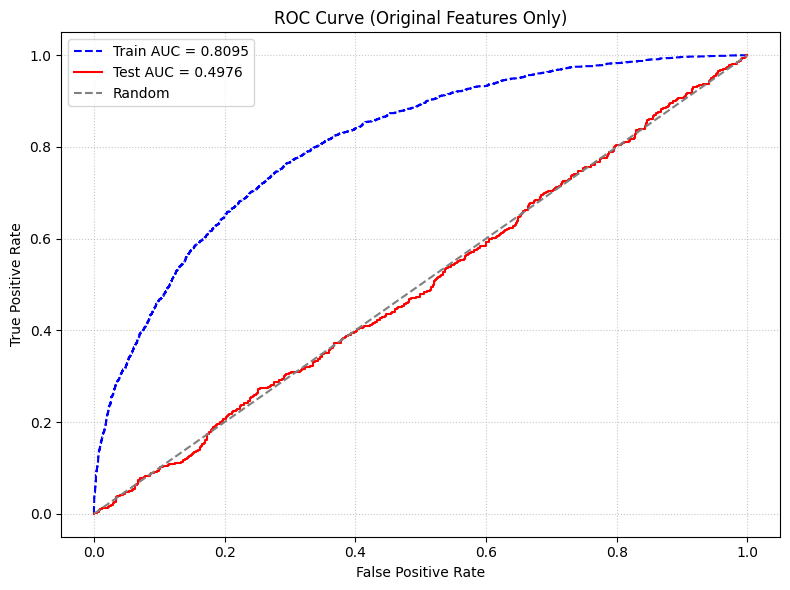

✅ 仅使用原始特征的模型训练与评估完成！


In [1]:
import os
import pickle
import numpy as np
from sklearn.metrics import roc_curve, auc
import xgboost as xgb
import matplotlib.pyplot as plt
import ehr_utils  # 确保这个模块可用

# 加载原始数据
X_train, X_test, y_train, y_test = ehr_utils.preprocess_ehr_train_test_data(
    'data_processed/benbu_baseline_cleaned_onehot.csv'
)

# 设置 XGBoost 参数
xgb_params = dict(
    colsample_bytree=1.0,
    device='gpu',
    eval_metric="auc",
    gamma=0.0,
    learning_rate=0.022403069086742198,
    max_depth=5,
    min_child_weight=100,
    n_estimators=589,
    n_jobs=-1,
    random_state=42,
    reg_alpha=0.14314863930500873,
    reg_lambda=100.0,
    subsample=0.7300248552604385
)

# 使用原始特征训练模型
model = xgb.XGBClassifier(**xgb_params)
model.fit(X_train, y_train)

# 预测概率
y_proba_train = model.predict_proba(X_train)[:, 1]
y_proba_test = model.predict_proba(X_test)[:, 1]

# 计算 ROC 曲线
fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

# 绘图
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, linestyle='--', color='blue', label=f'Train AUC = {auc_train:.4f}')
plt.plot(fpr_test, tpr_test, color='red', label=f'Test AUC = {auc_test:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Original Features Only)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

print("✅ 仅使用原始特征的模型训练与评估完成！")

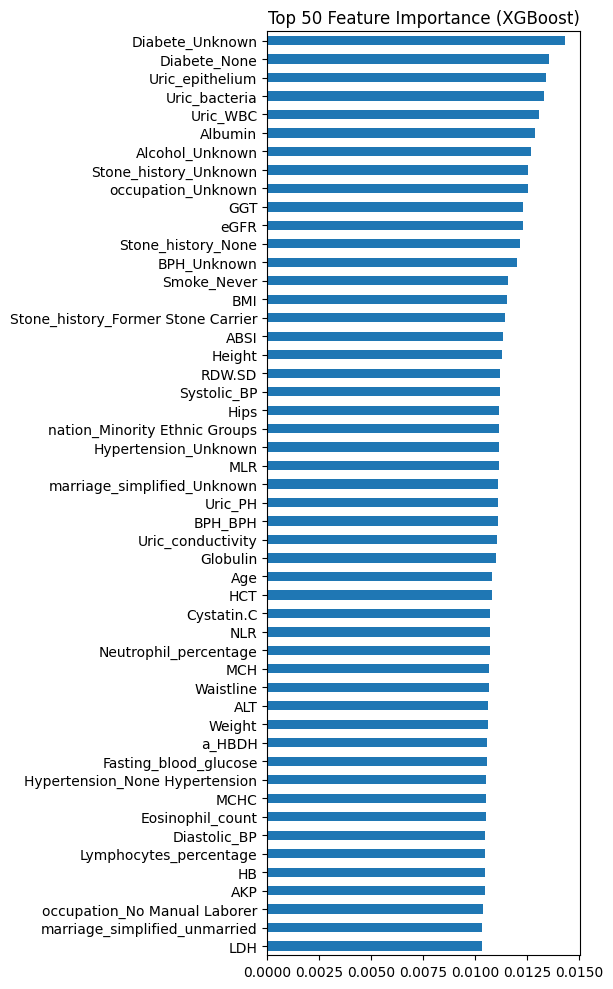

保留 96 / 96 个特征（重要性 > 0）


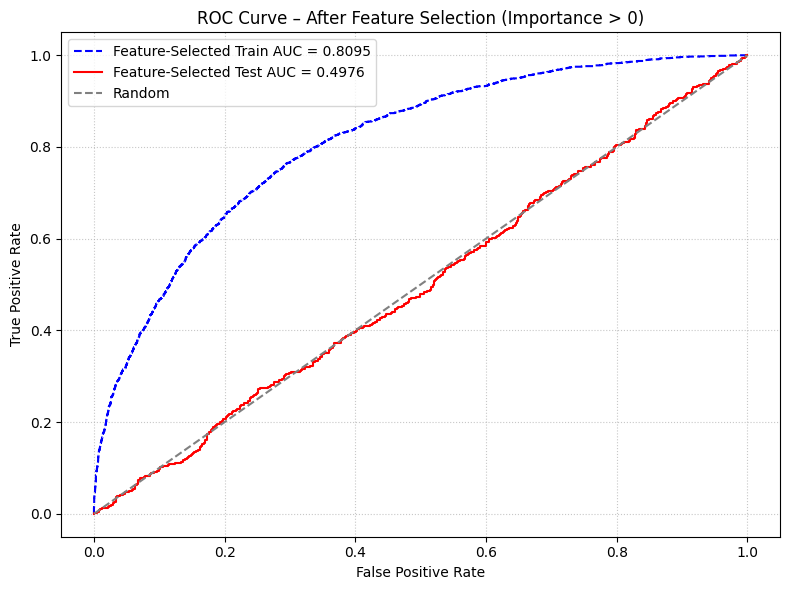

✅ 特征筛选完成，已重新训练并绘制 ROC！


In [2]:
# ========= 1. 基于原始模型得到特征重要性 =========
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 假设 X_train 是 DataFrame，方便对齐列名
if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train)
    X_test  = pd.DataFrame(X_test)

feat_imp = (
    pd.Series(model.feature_importances_, index=X_train.columns)
      .sort_values(ascending=False)
)

# 可视化 Top-N 重要性
top_n = 50   # 可调整
feat_imp.head(top_n).plot(kind='barh', figsize=(6, 10))
plt.gca().invert_yaxis()
plt.title(f'Top {top_n} Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()

# ========= 2. 选择重要性 > 0 的特征 =========
selected = feat_imp[feat_imp > 0].index.tolist()
print(f"保留 {len(selected)} / {X_train.shape[1]} 个特征（重要性 > 0）")

X_train_sel = X_train[selected]
X_test_sel  = X_test[selected]

# ========= 3. 用筛选后的特征重新训练 =========
model_sel = xgb.XGBClassifier(**xgb_params)
model_sel.fit(X_train_sel, y_train)

# 预测
y_proba_train_sel = model_sel.predict_proba(X_train_sel)[:, 1]
y_proba_test_sel  = model_sel.predict_proba(X_test_sel)[:, 1]

# ROC
fpr_train_sel, tpr_train_sel, _ = roc_curve(y_train, y_proba_train_sel)
fpr_test_sel,  tpr_test_sel,  _ = roc_curve(y_test,  y_proba_test_sel)
auc_train_sel = auc(fpr_train_sel, tpr_train_sel)
auc_test_sel  = auc(fpr_test_sel,  tpr_test_sel)

# ========= 4. 画图对比 =========
plt.figure(figsize=(8, 6))
plt.plot(fpr_train_sel, tpr_train_sel, linestyle='--', color='blue',
         label=f'Feature-Selected Train AUC = {auc_train_sel:.4f}')
plt.plot(fpr_test_sel,  tpr_test_sel,  color='red',
         label=f'Feature-Selected Test AUC = {auc_test_sel:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – After Feature Selection (Importance > 0)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

print("✅ 特征筛选完成，已重新训练并绘制 ROC！")

最优特征数: 14
对应 CV-AUC: 0.5133


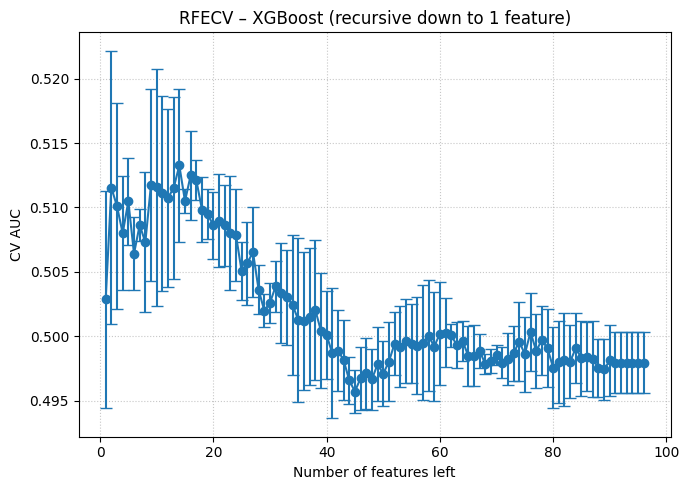

最终保留特征: ['Albumin', 'GGT', 'Height', 'Lymphocytes_percentage', 'MLR', 'RDW.SD', 'TBIL', 'Uric_WBC', 'Uric_epithelium', 'Hypertension_Hypertension', 'Stone_history_None', 'marriage_simplified_unmarried', 'nation_Minority Ethnic Groups', 'occupation_Unknown']
测试集 AUC (只剩 14 个特征): 0.4890


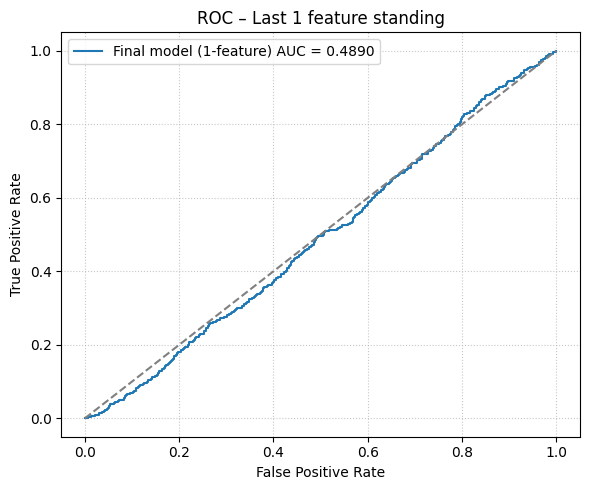

In [4]:
# ========= 1. 基础包 =========
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import xgboost as xgb

# 如果之前 X_train 是 ndarray，先转 DataFrame 方便对齐列名
if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train)
    X_test  = pd.DataFrame(X_test)

# ========= 2. 构造基模型（用原来的超参） =========
base_estimator = xgb.XGBClassifier(
    colsample_bytree=1.0,
    device='gpu',
    eval_metric='auc',
    gamma=0.0,
    learning_rate=0.022403069086742198,
    max_depth=5,
    min_child_weight=100,
    n_estimators=589,
    n_jobs=-1,
    random_state=42,
    reg_alpha=0.14314863930500873,
    reg_lambda=100.0,
    subsample=0.7300248552604385
)

# ========= 3. RFECV 递归消除 =========
# 关键参数：cv 折数、评分函数、最小保留 1 个特征
rfecv = RFECV(
    estimator=base_estimator,
    step=1,                       # 每次迭代去掉 1 个特征
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='roc_auc',
    min_features_to_select=1,     # 一直减到 1 个
    n_jobs=-1
)

rfecv.fit(X_train, y_train)

# ========= 4. 结果查看 =========
print("最优特征数:", rfecv.n_features_)
print("对应 CV-AUC: {:.4f}".format(rfecv.cv_results_['mean_test_score'][rfecv.n_features_ - 1]))

# 把 CV 结果整理成 DataFrame
cv_df = pd.DataFrame({
    'n_features': np.arange(1, len(rfecv.cv_results_['mean_test_score']) + 1),
    'mean_auc': rfecv.cv_results_['mean_test_score'],
    'std_auc':  rfecv.cv_results_['std_test_score']
})

# ========= 5. 画“特征数 vs AUC” =========
plt.figure(figsize=(7, 5))
plt.errorbar(cv_df.n_features, cv_df.mean_auc, yerr=cv_df.std_auc,
             marker='o', capsize=4, elinewidth=1.5)
plt.xlabel('Number of features left')
plt.ylabel('CV AUC')
plt.title('RFECV – XGBoost (recursive down to 1 feature)')
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

# ========= 6. 用最终选定的特征重新训练 & 测试 =========
X_train_final = X_train.loc[:, rfecv.support_]
X_test_final  = X_test.loc[:,  rfecv.support_]

print("最终保留特征:", list(X_train_final.columns))

final_model = xgb.XGBClassifier(**base_estimator.get_params())
final_model.fit(X_train_final, y_train)

# 评估
y_pred_proba = final_model.predict_proba(X_test_final)[:, 1]
final_auc = roc_auc_score(y_test, y_pred_proba)
print("测试集 AUC (只剩 {} 个特征): {:.4f}".format(X_train_final.shape[1], final_auc))

# ========= 7. ROC 曲线 =========
from sklearn.metrics import roc_curve, auc as calc_auc

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'Final model (1-feature) AUC = {final_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC – Last 1 feature standing')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()